# PH 1975 Project

## Design and implement your own Python program that can do following:

### 1. A crawler module that can collect paper title, author list, publication time, and abstract from PUBMED for a given keyword (i.e., HIV) within a pre-specified time window (that is, 01/01/2020 – 09/01/2020), and the retrieved data should be saved in the CSV format. (Hint: you may use BioPython, and an example of this can be found on stackoverflow)

In [1]:
import re
import numpy as np
from Bio import Entrez, Medline
import csv


#Enter your email
Entrez.email = "garret.munoz@uth.tmc.edu"

def date_converter(input_date):
    '''
    input_date: string of date and must have format MM/DD/YYYY
    outputs a string with for the date in format YYYY/MM/DD
    This will not catch months that don't exist such as 13 etc.
    '''
    #Checks if it matches the needed date format
    
    match = re.match("[0-1][0-9]/[0-3][0-9]/[0-9]{4}", input_date)
    if match is not None:
        output_date = input_date.split('/')
        output_date = output_date[2] + '/' + output_date[0] + '/' + output_date[1]
    else:
        raise Exception("Date must be in format MM/DD/YYYY")
    
    if int(input_date[0:2]) > 12 or int(input_date[0:2]) < 1:
        raise Exception("Month must be between 1 and 12")

    if int(input_date[3:5]) > 31 or int(input_date[3:5]) < 1:
        raise Exception("Dates must be between 1 and 31") 
    return output_date

def pubmed_crawl(key_term, mindate, maxdate):
    '''
    searches publications based on a key term between the mindate and maxdate
    key_term: string value of the topic to be searched
    mindate: minimum date of publication in format of 'YYYY/MM/DD'
    maxdate: maximum date of publication in format of 'YYYY/MM/DD'
    
    TODO: Notice mindate and maxdate utilize a different date format than given by
    the specifications (MM/DD/YYYY), we will need to clean the inputted date to the format that
    Entrez requires (YYYY/MM/DD). We should also have a check that the length of the inputted dates
    are equal to 10
    '''

    #mindate must be less than or equal to the maxdate
    assert (maxdate>=mindate), 'End date must be after or on start date'

    #queries for the ID by key term
    handle = Entrez.esearch(db="pubmed", term=key_term, retmax=100000,datetype='edat' ,mindate=mindate, maxdate=maxdate)
    record = Entrez.read(handle)
    idlist = record['IdList']
    handle.close()
    
    article_count = len(idlist)

    #retrieves publication data by the id's
    records = []
    retstart_list = [x for x in range(0, article_count, 1000)]
    for retstart in retstart_list:
        handle = Entrez.efetch(db="pubmed", id=idlist, 
        rettype="medline", retmode="text", 
        retstart=retstart, retmax=1000)
        txt_output = Medline.parse(handle)
        for record in txt_output:
            records.append(record)
        handle.close()
    return records

#TODO Parse the PMID, authors, abstract, and publication time from the outputted data
# and then export results to csv

def pubmed_parser(input_record):

    pmid =  int(input_record['PMID'])
    try:
        title = input_record['TI']
    except KeyError:
        #there are some articles that have no abstract
        return None
    try:
        abstract = input_record['AB']
    except KeyError:
        #there are some articles that have no abstract
        abstract = ''
    try:
        pub_date = input_record['EDAT'][0:10]
    except KeyError:
        return None
    try:
        authors = input_record['FAU']
    except KeyError:
        return None

    output_record = {'PMID': pmid, 'Authors':authors,
                     'Pub_Date': pub_date, 'Abstract':abstract,
                     'Title':title}

    return output_record

#test def
def hiv_crawl_test():
    key_word = 'HIV'
    min_date = '01/01/2020'
    max_date = '03/01/2020'

    min_date = date_converter(min_date)
    max_date = date_converter(max_date)

    pub_data = pubmed_crawl(key_word, min_date, max_date)

    return pub_data

def data_outputter(pub_data):
    output_pub_data = []
    for record in pub_data:
        parsed_record = pubmed_parser(record)
        if parsed_record is not None:
            output_pub_data.append(parsed_record)
    return output_pub_data

def pub_prompt(file_name):

    assert (file_name.endswith('csv')), 'file_name must be a .csv file'

    key_word = input('Key Word to search: ')
    assert (len(key_word) > 0), 'A key word must be used'
    
    min_date = input('Start date (MM/DD/YYYY): ')
    max_date = input('End date (MM/DD/YYYY): ')
    min_date = date_converter(min_date)
    max_date = date_converter(max_date)
    
    pub_data = pubmed_crawl(key_word, min_date, max_date)
    output_pub_data = data_outputter(pub_data)

    with open(file_name, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=output_pub_data[0].keys())
        writer.writeheader()
        writer.writerows(output_pub_data)
    
    print('query outputted {} publications'.format(len(output_pub_data)))
    print('file written to {}'.format(file_name))
    return True

if __name__ == "__main__":
    pub_prompt('publication_output.csv')

query outputted 10297 publications
file written to publication_output.csv


### 2. A database module that can import the CSV file to SQLite to build a database automatically. Then implement SQL code to query the publications by author’s name (i.e., input an author’s name and find out and return all his/her publications).

In [2]:
import ast
import csv
import sqlite3
import pandas as pd

def create_tables(conn):
    '''Drops and creates sqlite tables'''
    
    c = conn.cursor()

    c.execute('''DROP TABLE if exists publications;''')
    c.execute('''CREATE TABLE publications
                (PMID integer, Abstract text, Title text, Pub_Date text,
                PRIMARY KEY (PMID))''')

    c.execute('''DROP TABLE if exists authors;''')
    c.execute('''CREATE TABLE authors
                (AID integer, PMID integer, Full_Name text, Last_Name text, First_Name text,
                PRIMARY KEY (AID))''')
    c.execute('''CREATE INDEX idx_author_name ON authors (PMID);''')
    conn.commit()
    return 'Created tables'

def load_file(conn, pub_df):
    '''
    conn: connection to database
    pub_df: pandas dataframe from the pub_crawler.py csv
    Modifies the dataframe and prepares it load into the
    tables authors and publications
    '''

    #converts strings of the authors to a list
    pub_df['Authors'] = pub_df['Authors'].apply(lambda x: ast.literal_eval(x))
    pub_df['Pub_Date'] = pd.to_datetime(pub_df['Pub_Date'], yearfirst=True)

    #creates a row for each author for each pmid
    author_df = pub_df[['PMID','Authors']].explode('Authors')
    author_df = author_df.reset_index(drop=True)
    #separates the authors name into two columns, 
    name_df = author_df['Authors'].str.split(',', 1).apply(pd.Series)
    author_df = pd.concat([author_df, name_df], axis=1)
    author_df = author_df.reset_index()
    author_df = author_df.rename(columns={0:'Last_Name', 1:'First_Name', 
                                          'Authors':'Full_Name','index':'AID'})
    author_df['First_Name']= author_df['First_Name'].str.strip()
    author_df['Last_Name']= author_df['Last_Name'].str.strip()
    pub_columns= ['PMID','Pub_Date','Abstract','Title']

    #imports the data into the tables created
    author_df.to_sql('authors', conn, index=False, if_exists='append')
    pub_df[pub_columns].to_sql('publications', conn, index=False, if_exists='append')
    return 'Data Loaded'

def author_query(conn, first_name, last_name):
    c = conn.cursor()
    c.execute('''
    SELECT pubs.PMID, pubs.Abstract, pubs.Title, 
           pubs.Pub_Date, auth.AID, auth.Full_Name
    FROM publications pubs inner join authors auth on auth.PMID = pubs.PMID 
    WHERE Last_Name like ? and First_Name like ?;
    ''', (last_name+'%', first_name+'%'))
    return c.fetchall()

def author_search_prompt():

    first_name = input("Enter first name of author you would like to search: ")
    last_name = input('Enter last name of author you would like to search: ')
    
    if len(first_name) == 0 and len(last_name) == 0:
        raise Exception("A first or last name must be submitted")
    elif len(first_name) == 0:
        print("WARNING: This will search for all authors with last name {}".format(last_name))
    elif len(last_name) == 0:
        print("WARNING: This will search for all authors with first name {}".format(first_name))

    return {'first_name':first_name, 'last_name':last_name}


if __name__ == "__main__":

    conn = sqlite3.connect("publications.db")
    create_tables(conn)
    
    pub_df = pd.read_csv('publication_output.csv')
    load_file(conn, pub_df)

    author_search_dict = author_search_prompt()
    output_data = author_query(conn, author_search_dict['first_name'],author_search_dict['last_name'])
    
    for i in output_data:
        print(i[2])
    conn.close()


Risk factors for COVID-19 death in a population cohort study from the Western Cape Province, South Africa.


### 3. A visualization module that can i) read the CSV file, ii) show the number of publications in each year, iii) visualize the trend of the publication numbers over time, and iv) generate and visualize the summary statistics for the publication number per year, including mean, SD, range, median, 1st to 3rd quartile. Be creative about this one (e.g., you can create your own dashboard).


The dataset has 10297 publications.
The range of the number of publications is 1509.


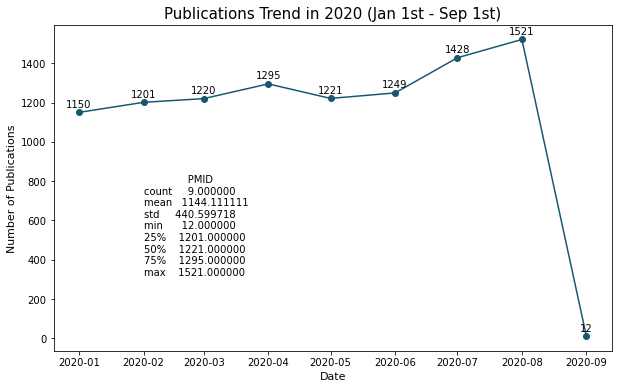

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 



def pub_line_plot(input_df):
    # print("Our dataset have {} rows and {} columns." .format(input_df.shape[0], input_df.shape[1]))
    monthly_counts = input_df.resample('MS')[['PMID']].count()
    monthly_descriptions = monthly_counts.describe()

    plt.rcParams["figure.figsize"] = (10,6)
    plt.plot(monthly_counts.index, monthly_counts["PMID"], color='#175871', marker='o')
    plt.title('Publications Trend in 2020 (Jan 1st - Sep 1st)',  fontsize=15)
    plt.xlabel('Date',  fontsize=11)
    plt.ylabel('Number of Publications', fontsize=11)
    plt.figtext(0.25, 0.3, monthly_descriptions.to_string())
    for x,y in zip(monthly_counts.index, monthly_counts["PMID"]):
        label = y
        plt.annotate(label, (x,y), textcoords="offset points", xytext=(0, 5), ha='center')
    # plt.grid(True)
    plt.show()

    
    return True


def pub_descriptions(input_df, print_output=True):
    monthly_counts = input_df.resample('M')[['PMID']].count()
    monthly_descriptions = monthly_counts.describe()
    range = int(monthly_descriptions.loc['max']-monthly_descriptions.loc['min'])

    if print_output == True:
        print("The dataset has {} publications." .format(input_df.shape[0]))
        print("The range of the number of publications is {}." .format(range))
        # print("The earliest publication was published on {:%m/%d/%Y}" .format(pub_df.index.min()))
        # print("The last publication was published on {:%m/%d/%Y}" .format(pub_df.index.max()))
        # print("There were a total of {:d} months".format(int(monthly_descriptions.loc['count'][0])))
  

    return monthly_counts, monthly_descriptions


if __name__ == '__main__':
    pub_df = pd.read_csv("publication_output.csv", index_col=['Pub_Date'], parse_dates=['Pub_Date'])
    pub_descriptions(pub_df)
    pub_line_plot(pub_df)